In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import warnings 
warnings.filterwarnings('ignore')


In [2]:
# predict customer will repay their within 90 days- binary classification
df = pd.read_csv('credit_scoring_sample.csv')

In [3]:
"""
debtRatio: loan payment/total monthly income
numberoftime30-59days: number of case  client has overdue 30-59 days on other loans during last 2 years
numberoftime90dayasLate: number of case overdue 90+ days
number of dependents: number of customer dependents
serious diqin 2yrs: customer hasn't paid loan debt within 90 days
"""

"\ndebtRatio: loan payment/total monthly income\nnumberoftime30-59days: number of case  client has overdue 30-59 days on other loans during last 2 years\nnumberoftime90dayasLate: number of case overdue 90+ days\nnumber of dependents: number of customer dependents\nserious diqin 2yrs: customer hasn't paid loan debt within 90 days\n"

In [4]:
# remove the missing value
def fill_nan(table):
    for col in table.columns:
        table[col] = table[col].fillna(table[col].median())
    return table



Distribution of target


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

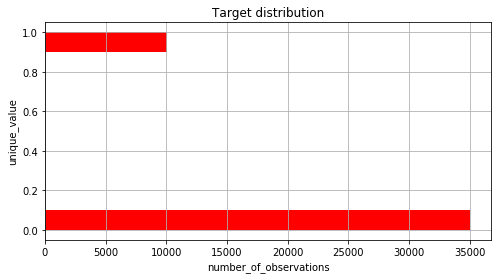

In [5]:
# let's check training sample distribution
fig, ax = plt.subplots(figsize=(8,4))
ax = df["SeriousDlqin2yrs"].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of target')
df["SeriousDlqin2yrs"].value_counts()/df.shape[0]

In [6]:
df_fillna = fill_nan(df)
feature = [x for x in df_fillna if x!="SeriousDlqin2yrs"] # for x in data-> show all columns
y = df_fillna["SeriousDlqin2yrs"]
X = df_fillna[feature]

In [7]:
def get_bootstrap_samples(data, n_samples):
    """Generate samples using bootstrapping."""
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    """Make an interval estimate."""
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

# Save the ages of those who let a delay
churn = df_fillna[df_fillna['SeriousDlqin2yrs'] == 1]['age'].values

# Set the random seed for reproducibility 
np.random.seed(0)

# Generate bootstrap samples and calculate the mean for each sample
churn_mean_scores = [np.mean(sample) for sample in get_bootstrap_samples(churn, 1000).T]

# Print the interval estimate for the sample means
print("Mean interval", stat_intervals(churn_mean_scores, 0.1))

Mean interval [45.25425 46.60075]


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score

lr = LogisticRegression(random_state=5, class_weight='balanced')
skf = StratifiedKFold(random_state=5,n_splits=5,shuffle=True)
parameters = {'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)}

train_ac = []
test_ac = []
for param in parameters['C']:
    lr = LogisticRegression(random_state=5, class_weight='balanced', C=param)
    temp_test_results = []
    temp_roc_results = []
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = np.asarray(X.iloc[train_idx]), np.asarray(X.iloc[test_idx])
        y_train, y_test = np.asarray(y.iloc[train_idx]), np.asarray(y.iloc[test_idx])
        lr.fit(X_train, y_train)
        temp_test_results.append(lr.score(X_test, y_test))
        temp_roc_results.append(roc_auc_score(y_test, lr.predict(X_test)))

    print("param C:{}, cv_accuracy: {: .2f}%, roc_auc: {: .2f}%".format(param,
                                                                      np.mean(temp_test_results)*100,
                                                                     np.mean(temp_roc_results)*100 ))
    
    
    


param C:0.0001, cv_accuracy:  81.04%, roc_auc:  70.25%
param C:0.001, cv_accuracy:  80.42%, roc_auc:  72.07%
param C:0.01, cv_accuracy:  76.46%, roc_auc:  71.61%
param C:0.1, cv_accuracy:  75.38%, roc_auc:  71.41%
param C:1, cv_accuracy:  75.12%, roc_auc:  71.29%
param C:10, cv_accuracy:  75.05%, roc_auc:  71.24%


In [34]:
# grid search cv
grid_search = GridSearchCV(lr, parameters, n_jobs=-1, scoring='roc_auc', cv=skf)
grid_search = grid_search.fit(X, y)
grid_search.best_score_

0.7954094396943863

In [10]:
grid_search.cv_results_["std_test_score"][1]

0.006357440975938697

In [25]:
# feature importance
# find which feature have most impact in model
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_norm = scaler.transform(X)
feature_columns = X.columns
lr = LogisticRegression(random_state=5, class_weight='balanced', C=0.001)
lr.fit(X_norm, y)
feat_weights = lr.coef_
feat_names = X.columns

feat_importance = pd.DataFrame({'feat': feat_names,'coef': feat_weights.flatten()}).sort_values(by='coef',ascending=False)

In [26]:
feat_importance

,feat,coef
1,NumberOfTime30-59DaysPastDueNotWorse,0.724004
3,NumberOfTimes90DaysLate,0.517673
4,NumberOfTime60-89DaysPastDueNotWorse,0.194732
6,NumberOfDependents,0.101326
2,DebtRatio,-0.024082
5,MonthlyIncome,-0.162864
0,age,-0.416304


In [29]:
X_modify = X.copy()
X_modify['age'] = X_modify['age']+20